# Checkpoint 3
## SVM

In [1]:
!pip install 'dtreeviz'

In [2]:
!wget https://raw.githubusercontent.com/dlevi150/7506R-2C2023-GRUPO33/main/CHP1/datasets/hotels_train.csv

--2023-10-20 00:38:12--  https://raw.githubusercontent.com/dlevi150/7506R-2C2023-GRUPO33/main/CHP1/datasets/hotels_train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9788953 (9.3M) [text/plain]
Saving to: ‘hotels_train.csv.1’

hotels_train.csv.1  100%[===================>]   9.33M  --.-KB/s    in 0.09s   

2023-10-20 00:38:13 (103 MB/s) - ‘hotels_train.csv.1’ saved [9788953/9788953]



In [3]:
!wget https://raw.githubusercontent.com/dlevi150/7506R-2C2023-GRUPO33/main/CHP1/datasets/hotels_test.csv

--2023-10-20 00:38:13--  https://raw.githubusercontent.com/dlevi150/7506R-2C2023-GRUPO33/main/CHP1/datasets/hotels_test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4432981 (4.2M) [text/plain]
Saving to: ‘hotels_test.csv.1’

hotels_test.csv.1   100%[===================>]   4.23M  --.-KB/s    in 0.08s   

2023-10-20 00:38:13 (56.0 MB/s) - ‘hotels_test.csv.1’ saved [4432981/4432981]



In [4]:
import pandas as pd
import numpy as np

#Visualización
import matplotlib.pyplot as plt
import seaborn as sns
import dtreeviz

#modelos y métricas
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score,f1_score#, precision_recall_curve, roc_curve,
from sklearn.metrics import confusion_matrix, classification_report

#preprocesamiento
from sklearn.preprocessing import MinMaxScaler

#SVM
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.datasets import make_classification

#configuración warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [5]:
df = pd.read_csv("hotels_train.csv")

df_filtrado = df.copy()

# Modificando el dataset

In [6]:
df_filtrado = df_filtrado.drop('id', axis=1)

In [7]:
#mapeamos los meses a numeros
months_dict = {
    'January': 1,
    'February': 2,
    'March': 3,
    'April': 4,
    'May': 5,
    'June': 6,
    'July': 7,
    'August': 8,
    'September': 9,
    'October': 10,
    'November': 11,
    'December': 12
}

def mapear_mes_a_numero(fecha):
    if(np.nan == fecha):
        return -1
    return months_dict.get(fecha)

df_filtrado['arrival_date_month'] = df_filtrado['arrival_date_month'].apply(mapear_mes_a_numero)


formato_fecha = "%Y-%m-%d"

df_filtrado['date'] = pd.to_datetime(df_filtrado[['arrival_date_year', 'arrival_date_month', 'arrival_date_day_of_month']].astype(str).agg('-'.join, axis=1), format=formato_fecha)
df_filtrado['ordinal date'] = df_filtrado.date.apply(lambda x: x.toordinal())
df_filtrado.drop('date',axis=1, inplace=True)
df_filtrado.head(2)

,hotel,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,is_canceled,ordinal date
0,City Hotel,49,2016,9,37,5,1,2,1,0.0,...,No Deposit,9.0,NaN,0,Transient,115.5,0,1,1,736212
1,Resort Hotel,4,2015,10,44,31,0,1,2,0.0,...,No Deposit,NaN,NaN,0,Transient,42.0,1,0,0,735902


In [8]:
# Reemplazando NANs
df_filtrado.children = df_filtrado.children.replace(np.nan, 0)
df_filtrado.agent = df_filtrado.agent.replace(np.nan, -1)
df_filtrado.company = df_filtrado.company.replace(np.nan, -1)
df_filtrado['country'] = df_filtrado['country'].replace(np.nan, 'PRT')

In [9]:
# Corrigiendo algunos outliers
df_filtrado = df_filtrado.replace({'adults': 0}, value=2)
df_filtrado = df_filtrado.replace({'children': 10}, value=0)
df_filtrado = df_filtrado.replace({'babies': 9}, value=0)
df_filtrado = df_filtrado.replace({'adr': -6.38}, value=df_filtrado['adr'].median())
df_filtrado = df_filtrado.replace({'adr': 0}, value=df_filtrado['adr'].median())

# Encoding and Separation columns

In [10]:
ds_encodeado = pd.get_dummies(df_filtrado, columns=["hotel", "arrival_date_month","meal","country","market_segment","distribution_channel","reserved_room_type","assigned_room_type","deposit_type", "customer_type"], drop_first=True)
ds_encodeado.head(3)

,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,...,assigned_room_type_H,assigned_room_type_I,assigned_room_type_K,assigned_room_type_L,assigned_room_type_P,deposit_type_Non Refund,deposit_type_Refundable,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
0,49,2016,37,5,1,2,1,0.0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,4,2015,44,31,0,1,2,0.0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,25,2016,42,13,0,1,2,2.0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [11]:
ds_trabajo_x=ds_encodeado.drop(['is_canceled'], axis='columns', inplace=False)

ds_trabajo_y = ds_encodeado['is_canceled'].copy()

x_train, x_test, y_train, y_test = train_test_split(ds_trabajo_x,
                                                    ds_trabajo_y,
                                                    test_size=0.9,
                                                    random_state=2)

## Normalizacion de Datos
Elegimos hacer la version de estandarizada

In [12]:
#Armo una version estandarizada
stand_scaler = preprocessing.StandardScaler()
x_train_norm = stand_scaler.fit_transform(x_train.sort_index(axis=1))
x_test_norm = stand_scaler.transform(x_test.sort_index(axis=1))

## Sin Hiperparametros

In [13]:
def metricas(y_pred,y_test):

  print(classification_report(y_test,y_pred))

  cm = confusion_matrix(y_test,y_pred)
  sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
  plt.xlabel('Predicted')
  plt.ylabel('True')

              precision    recall  f1-score   support

           0       0.79      0.83      0.81     27851
           1       0.82      0.78      0.80     27871

    accuracy                           0.80     55722
   macro avg       0.81      0.80      0.80     55722
weighted avg       0.81      0.80      0.80     55722



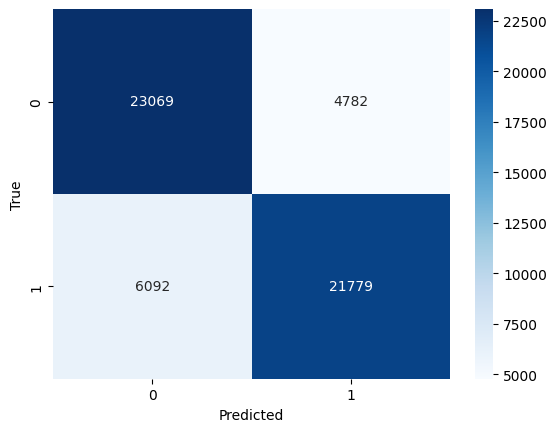

In [14]:
#Construyo un modelo SVM
svm_norm= SVC()

#Lo entreno con los datos escalados con normalizacion
svm_norm.fit(x_train_norm, y_train)

#Hago la prediccion y calculo las métricas
y_pred_norm=svm_norm.predict(x_test_norm)
metricas(y_pred_norm,y_test)

In [15]:
accuracy=accuracy_score(y_test,y_pred_norm)
recall=recall_score(y_test,y_pred_norm)
f1=f1_score(y_test,y_pred_norm)
precision=precision_score(y_test,y_pred_norm)

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

Accuracy: 0.8048526614263666
Recall: 0.7814215492806142
Precision: 0.819961597831407
f1 score: 0.8002278071722516


## Con Hiperparametros Elegidos a Mano

"El *parámetro de regularización* **C** que controla el equilibrio entre el doble objetivo de maximizar el margen y minimizar el error cometido. **C** multiplica a los errores cometidos, de forma que un valor bajo de **C** tiende a penalizar poco los errores, permitiendo márgenes mayores a costa de cometer más errores (baja regularización), mientras que un valor alto de **C** penaliza mucho los errores, llevando al modelo a cometer menos errores a costa de un margen menor (alta regularización)."

Fuente: https://interactivechaos.com/es/manual/tutorial-de-machine-learning/el-parametro-de-regularizacion-c

              precision    recall  f1-score   support

           0       0.79      0.81      0.80     27851
           1       0.81      0.78      0.79     27871

    accuracy                           0.80     55722
   macro avg       0.80      0.80      0.80     55722
weighted avg       0.80      0.80      0.80     55722



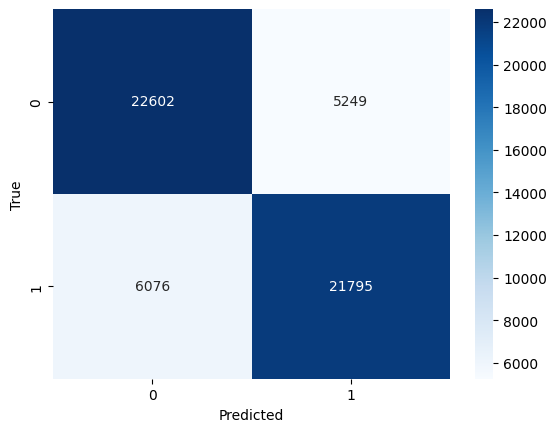

In [16]:
#Creo un clasificador con kernel lineal y lo entreno sobre los datos escalados min-max
clf = SVC(kernel='linear', C=5)
clf.fit(x_train_norm, y_train)

#Hago la predicción y calculo las métricas
y_pred_lin=clf.predict(x_test_norm)
metricas(y_pred_lin, y_test)

Como tenemos un sesgo suficientemente alto y no hay mucha sobrecorreccion, decidimos probar con un C bajo.

In [17]:
accuracy=accuracy_score(y_test,y_pred_norm)
recall=recall_score(y_test,y_pred_norm)
f1=f1_score(y_test,y_pred_norm)
precision=precision_score(y_test,y_pred_norm)

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

Accuracy: 0.8048526614263666
Recall: 0.7814215492806142
Precision: 0.819961597831407
f1 score: 0.8002278071722516


## Con Hiperparametros Elegidos Por Gridsearch/Randomsearch

In [18]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold, KFold,RandomizedSearchCV
from sklearn.metrics import make_scorer, f1_score

#Conjunto de parámetros que quiero usar
param_grid = {
    'C': np.arange(1, 100, 10),
    'degree': np.arange(2, 4, 1),
    'gamma': np.logspace(-4, 2, 10),
    'coef0': np.arange(-1, 1, 0.1),
}

#Cantidad de combinaciones que quiero porbar
n=5 #20

# #Cantidad de splits para el Cross Validation
folds=5

# #Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds)

# #Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(f1_score)

#Random Search Cross Validation

randomcv = RandomizedSearchCV(estimator=SVC(),
                              param_distributions=param_grid,
                              n_iter=n,
                              cv=kfoldcv,
                              scoring=scorer_fn,
                              random_state=2)

#Busco los hiperparamtros que optimizan F1 Score
randomcv.fit(x_train_norm, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=SVC(), n_iter=5,
                   param_distributions={'C': array([ 1, 11, 21, 31, 41, 51, 61, 71, 81, 91]),
                                        'coef0': array([-1.00000000e+00, -9.00000000e-01, -8.00000000e-01, -7.00000000e-01,
       -6.00000000e-01, -5.00000000e-01, -4.00000000e-01, -3.00000000e-01,
       -2.00000000e-01, -1.00000000e-01, -2.22...
        2.00000000e-01,  3.00000000e-01,  4.00000000e-01,  5.00000000e-01,
        6.00000000e-01,  7.00000000e-01,  8.00000000e-01,  9.00000000e-01]),
                                        'degree': array([2, 3]),
                                        'gamma': array([1.00000000e-04, 4.64158883e-04, 2.15443469e-03, 1.00000000e-02,
       4.64158883e-02, 2.15443469e-01, 1.00000000e+00, 4.64158883e+00,
       2.15443469e+01, 1.00000000e+02])},
                   random_state=2, scoring=make_scorer(f1_score))

In [19]:
#Mejores hiperparametros del arbol
print(randomcv.best_params_)
#Mejor métrica
print(randomcv.best_score_)

{'gamma': 0.00046415888336127773, 'degree': 2, 'coef0': -0.30000000000000016, 'C': 61}
0.7956096998726998


In [20]:
svm_norm = randomcv.best_estimator_

In [21]:
# #Construyo un modelo SVM
# svm_norm= SVC(
#               max_depth = randomcv.best_params_['max_depth'],
#               min_samples_leaf=randomcv.best_params_['min_samples_leaf'],
#               min_samples_split=randomcv.best_params_['min_samples_split'],
#               n_estimators=randomcv.best_params_['n_estimators'])

# #Lo entreno con los datos escalados con normalizacion
# svm_norm.fit(X = x_train_norm.sort_index(axis=1),y=y_train)

              precision    recall  f1-score   support

           0       0.80      0.82      0.81     27851
           1       0.81      0.80      0.81     27871

    accuracy                           0.81     55722
   macro avg       0.81      0.81      0.81     55722
weighted avg       0.81      0.81      0.81     55722



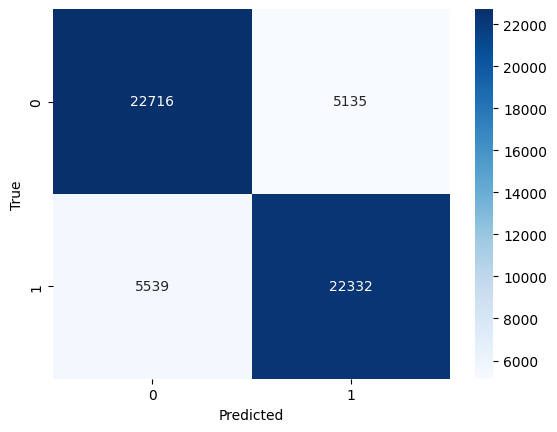

In [22]:
#Hago la prediccion y calculo las métricas
y_pred_norm=svm_norm.predict(x_test_norm)
metricas(y_pred_norm,y_test)

Text(50.722222222222214, 0.5, 'True')

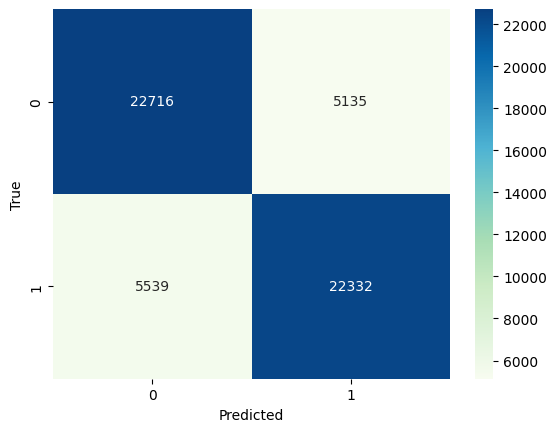

In [23]:
tabla=confusion_matrix(y_test, y_pred_norm)

#Grafico la matriz de confusión
sns.heatmap(tabla,cmap='GnBu',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

In [24]:
accuracy=accuracy_score(y_test,y_pred_norm)
recall=recall_score(y_test,y_pred_norm)
f1=f1_score(y_test,y_pred_norm)
precision=precision_score(y_test,y_pred_norm)

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

Accuracy: 0.8084419080435017
Recall: 0.801262961501202
Precision: 0.8130483853351295
f1 score: 0.8071126531497343


In [25]:
print(classification_report(y_test,y_pred_norm))

              precision    recall  f1-score   support

           0       0.80      0.82      0.81     27851
           1       0.81      0.80      0.81     27871

    accuracy                           0.81     55722
   macro avg       0.81      0.81      0.81     55722
weighted avg       0.81      0.81      0.81     55722



# Test prediction

## Modificando el Dataset de Test

In [26]:
df_test = pd.read_csv("hotels_test.csv")
df_test_filtrado = df_test.copy()

In [27]:
df_test_ids = df_test['id']
df_test_filtrado = df_test_filtrado.drop('id', axis=1)
df_test_filtrado = df_test_filtrado.drop('reservation_status_date', axis=1)

In [28]:
#mapeamos los meses a numeros
months_dict = {
    'January': 1,
    'February': 2,
    'March': 3,
    'April': 4,
    'May': 5,
    'June': 6,
    'July': 7,
    'August': 8,
    'September': 9,
    'October': 10,
    'November': 11,
    'December': 12
}

def mapear_mes_a_numero(fecha):
    if(np.nan == fecha):
        return -1
    return months_dict.get(fecha)

df_test_filtrado['arrival_date_month'] = df_test_filtrado['arrival_date_month'].apply(mapear_mes_a_numero)


formato_fecha = "%Y-%m-%d"

df_test_filtrado['date'] = pd.to_datetime(df_test_filtrado[['arrival_date_year', 'arrival_date_month', 'arrival_date_day_of_month']].astype(str).agg('-'.join, axis=1), format=formato_fecha)
df_test_filtrado['ordinal date'] = df_test_filtrado.date.apply(lambda x: x.toordinal())
df_test_filtrado.drop('date',axis=1, inplace=True)
df_test_filtrado.head(2)

,hotel,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,ordinal date
0,City Hotel,277,2016,11,46,7,1,2,2,0.0,...,0,Non Refund,NaN,NaN,0,Transient,100.0,0,0,736275
1,City Hotel,286,2016,5,20,11,0,4,2,0.0,...,0,No Deposit,30.0,NaN,176,Transient-Party,101.0,0,0,736095


In [29]:
#Reemplazamos los NANs
df_test_filtrado['country'] = df_test_filtrado['country'].replace(np.nan, 'PRT')
df_test_filtrado.agent = df_test_filtrado.agent.replace(np.nan, -1)
df_test_filtrado.company = df_test_filtrado.company.replace(np.nan, -1)
df_filtrado.children = df_filtrado.children.replace(np.nan, 0)

In [30]:
lista_paises_unicos_test = df_test_filtrado['country'].unique()
lista_paises_unicos = df_filtrado['country'].unique()
conjunto1 = set(lista_paises_unicos)
conjunto2 = set(lista_paises_unicos_test)


# Obtener los elementos que están en conjunto1 pero no en conjunto2
elementos_en_lista1_no_en_lista2 = list(conjunto2 - conjunto1)
print(elementos_en_lista1_no_en_lista2)

df_test_filtrado["country"] = df_test_filtrado["country"].replace(to_replace=elementos_en_lista1_no_en_lista2, value="PRT")

['SMR', 'ATF', 'TMP', 'ASM', 'SLV', 'KHM', 'NIC', 'UZB', 'DJI', 'BFA', 'MLI', 'DMA']


In [31]:
# Cambiamos algunos outliers
df_test_filtrado["adr"] = df_test_filtrado["adr"].replace(to_replace=0, value=df_filtrado['adr'].median())
df_test_filtrado["adults"] = df_test_filtrado["adults"].replace(to_replace=0, value=2)

In [32]:
df_test_encodeado = pd.get_dummies(df_test_filtrado, columns=["hotel", "arrival_date_month","meal","country","market_segment","distribution_channel","reserved_room_type","assigned_room_type","deposit_type", "customer_type"], drop_first=True)


In [33]:
lista = df_test_encodeado.columns
columnas_faltantes = []
for colum in ds_encodeado.columns:
  if(colum not in lista and colum != "is_canceled"):
    # print(colum)
    columnas_faltantes.append(colum)

for colum_faltante in columnas_faltantes:
  df_test_encodeado[colum_faltante] = 0

In [34]:
df_test_encodeado = stand_scaler.transform(df_test_encodeado.sort_index(axis=1))

## Predecimos

In [36]:
test_pred_2 = clf.predict(df_test_encodeado)
#Valores Predichos
test_pred_2

array([1, 1, 0, ..., 1, 1, 0])

In [37]:
# Crear un DataFrame con las columnas "id" e "is_canceled"
data = {'id': df_test_ids, 'is_canceled': test_pred_2}
df_final_finalisimo = pd.DataFrame(data)

In [38]:
df_final_finalisimo.isna().any()

id             False
is_canceled    False
dtype: bool

In [39]:
df_final_finalisimo.to_csv('submission.csv', index=False)